In [1]:
import gzip, pickle
import os
import numpy as np
import pandas as pd
import random
import shutil
import numpy as np
import os, zipfile
import xml.etree.ElementTree as ET 
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from scipy import linalg
import matplotlib.pyplot as plt
import gc
import urllib
import warnings
from PIL import Image
from tqdm import tqdm_notebook as tqdm

In [2]:
with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as z:
    z.extractall(".")

In [3]:
with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as z:
    z.extractall(".")


In [4]:
dogs = os.listdir('./all-dogs/')

In [5]:
print("Total Images =", len(dogs))
print("Total breeds=", len(os.listdir('./Annotation')))

Total Images = 20579
Total breeds= 120


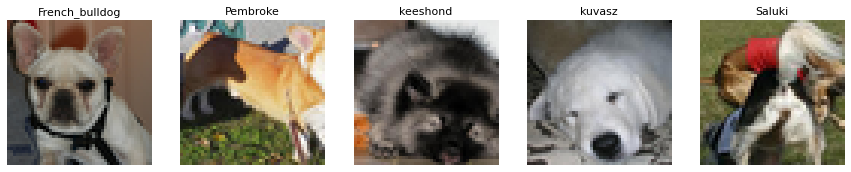

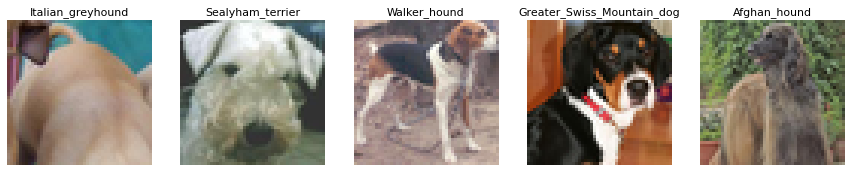

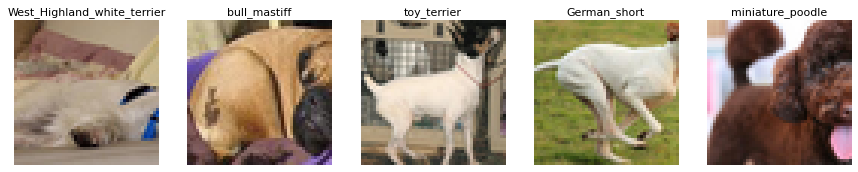

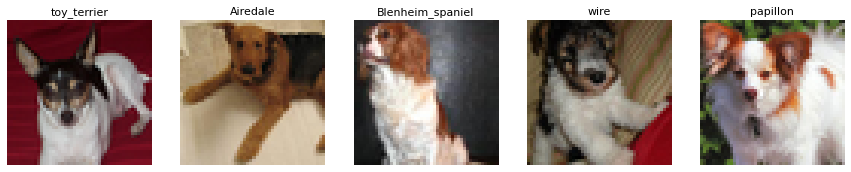

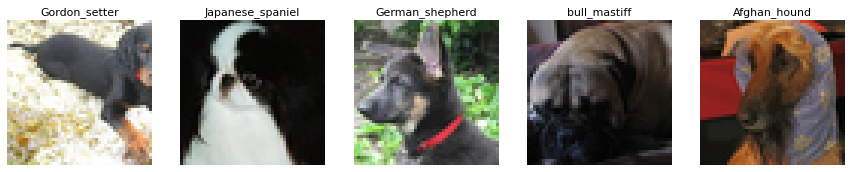

In [6]:
All_dogs = os.listdir('./all-dogs/')
All_breeds = os.listdir('./Annotation/') 
counter = 0; names = []
Training_dogs = np.zeros((25000,48,48,3))

for breed in All_breeds:
    for dog in os.listdir('./Annotation/'+breed):
        try: img = Image.open('./all-dogs/'+dog+'.jpg') 
        except: continue           
        tree = ET.parse('./Annotation/'+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((48,48), Image.ANTIALIAS)
            Training_dogs[counter,:,:,:] = np.asarray(img2)
            names.append(breed)
            counter += 1
idx = np.arange(counter)
np.random.shuffle(idx)
Training_dogs = Training_dogs[idx,:,:,:]
names = np.array(names)[idx]
    
x = np.random.randint(0,counter,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( Training_dogs[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(names[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()


In [7]:
print(Training_dogs.shape)
print(len(idx))

(22125, 48, 48, 3)
22125


In [8]:
class LayerNorm(nn.LayerNorm):
    
    def __init__(self, *args, **kwargs):
        
        super().__init__(*args, **kwargs)
    
    def forward(self, x):
        
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()
    
class ConcatLayerNorm(nn.Module):
    
    def __init__(self, n_filters):
        
        super().__init__()
        self.horizontal_layer_norm = LayerNorm(n_filters)
        self.vertical_layer_norm = LayerNorm(n_filters)
        
    def forward(self, x):
        
        vx, hx = x.chunk(2, dim = 1)
        vx, hx = self.vertical_layer_norm(vx), self.horizontal_layer_norm(hx)
        return torch.cat((vx, hx), dim = 1)

In [9]:
class GatedConv2d(nn.Module):
    
    def __init__(self, mask_type, in_channels, out_channels, k = 7,
                padding = 3):
        
        super().__init__()
        self.vstack = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=k,
                              padding=padding, bias=False)
        self.hstack = nn.Conv2d(in_channels, 2 * out_channels, kernel_size=(1, k),
                                padding=(0, padding), bias=False)
        self.vstack_access = nn.Conv2d(2 * out_channels, 2 * out_channels, kernel_size=1, 
                            bias=False)
        self.hstack_final = nn.Conv2d(out_channels, out_channels, kernel_size=1, 
                            bias=False)
        self.register_buffer('vmask', self.vstack.weight.data.clone())
        self.register_buffer('hmask', self.hstack.weight.data.clone())
        self.vmask.fill_(1)
        self.hmask.fill_(1)
        #bottom half of vertical mask is set zero for stop accessing 
        self.vmask[:, :, k // 2 + 1:, :] = 0
        #right half of horizontal mask is set zero
        self.hmask[:, :, :, k // 2 + 1:] = 0
        if mask_type == 'A':
            self.hmask[:, :, :, k // 2] = 0
            
    
    def down_shift(self, x):
        
        #padding a row of zero to adjust output shape
        x = x[:, :, :-1, :]
        pad = nn.ZeroPad2d((0, 0, 1, 0))
        return pad(x)
    
    def forward(self, x):
        
        vx, hx = x.chunk(2, dim=1)
        
        #masking weights
        self.vstack.weight.data *= self.vmask
        self.hstack.weight.data *= self.hmask
        vx = self.vstack(vx)
        hx_new = self.hstack(hx)
        
        #allowing vertical stack to see pixels of horizontal stack
        hx_new = hx_new + self.vstack_access(self.down_shift(vx))
        vx_1, vx_2 = vx.chunk(2, dim=1)
        
        #gating like mechanism similar to LSTM
        vx = torch.tanh(vx_1) * torch.sigmoid(vx_2)
        hx_1, hx_2 = hx_new.chunk(2, dim=1)
        hx_new = torch.tanh(hx_1) * torch.sigmoid(hx_2)
        
        #final 1 * 1 convolution
        hx_new = self.hstack_final(hx_new)
        
        #adding residual input
        hx = hx + hx_new
        return torch.cat((vx, hx), dim=1)


In [10]:
class MaskConv2d(nn.Conv2d):
    
    def __init__(self, mask_type, *args, **kwargs):
        
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
        
    def forward(self, input):
        
        batch_size = input.shape[0]
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
        return out
    
    def create_mask(self, mask_type):
        
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1

In [11]:
class GatedPixelCNN(nn.Module):
    
    def __init__(self, input_shape, n_colors, n_layers = 8, n_filters = 120):
        
        super().__init__()
        self.n_channels = input_shape[0]
        self.n_colors = n_colors
        self.input_shape = input_shape
        self.block_init = MaskConv2d('A', self.n_channels, n_filters, 7, padding=3)
        model = []
        for _ in range(n_layers - 2):
            
            model.extend([nn.ReLU(), GatedConv2d('B', n_filters, n_filters, 7, padding=3)])
            model.append(ConcatLayerNorm(n_filters))
        self.final_conv = MaskConv2d('B', n_filters, n_colors * self.n_channels, 7, padding=3)
        self.net = nn.Sequential(*model)
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        out = (x.float() / (self.n_colors - 1)) 
        out = self.block_init(out)
        out = self.net(torch.cat((out, out), dim=1)).chunk(2, dim=1)[1]
        out = self.final_conv(out)
        return out.view(batch_size, self.n_channels, self.n_colors, *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
    
    def loss(self, x):
        
        return F.cross_entropy(self(x), x.long())
    
    def sample(self, n):
        
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        logits = self(samples)[:, :, k, r, c]
                        probs = F.softmax(logits, dim = 1)
                        samples[:, k, r, c] = torch.multinomial(probs,1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()
        
        
        
        

In [12]:
def Train(model, train_loader, optimizer, epoch, grad_clip=None):
    
    model.train()
    pbar = tqdm(total=len(train_loader.dataset))
    train_losses = []
    for x in train_loader:
        x = x.cuda().contiguous()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.item())
        pbar.set_description(f'Epoch {epoch}, Train Loss {np.mean(train_losses[-50:]):.4f}')
        pbar.update(x.shape[0])
        pbar.close()
    return train_losses

def eval_loss(model, data_loader):
    
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        
        model.train()
        train_losses.extend(Train(model, train_loader, optimizer, epoch, grad_clip))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

    return train_losses, test_losses



In [13]:
torch.cuda.empty_cache()

In [14]:
train_data = np.transpose(Training_dogs[:16000, :, :, :], (0, 3, 1, 2))
test_data = np.transpose(Training_dogs[16000:17920, :, :, :], (0, 3, 1, 2))
model = GatedPixelCNN((3, 48, 48), 256, n_filters=120, n_layers=12).cuda()
train_args = dict(epochs=15, lr=1e-3, grad_clip=1)
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=32)
del Training_dogs
gc.collect()
train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           train_args)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Epoch 0, Test loss 4.1443



Epoch 1, Test loss 3.9948



Epoch 2, Test loss 3.9247



Epoch 3, Test loss 3.8640



Epoch 4, Test loss 3.8350



Epoch 5, Test loss 3.7702



Epoch 6, Test loss 3.7759



Epoch 7, Test loss 3.7472



Epoch 8, Test loss 3.7034



Epoch 9, Test loss 3.7080



Epoch 10, Test loss 3.6691



Epoch 11, Test loss 3.6855



Epoch 12, Test loss 3.7128



Epoch 13, Test loss 3.6740



Epoch 14, Test loss 3.6507


In [15]:
samples = model.sample(10) 

In [18]:
def show_d_images(imgs):
    with torch.no_grad():
        imgs = imgs.reshape((-1,48,48,3))
        for i in range(2):
            plt.figure(figsize=(20,4))
            for j in range(5):
                plt.subplot(1,5,j+1)
                img = Image.fromarray((imgs[i*2+j, :, :, :]).astype('uint8').reshape((48,48,3)))
                plt.imshow(img)
        plt.show();

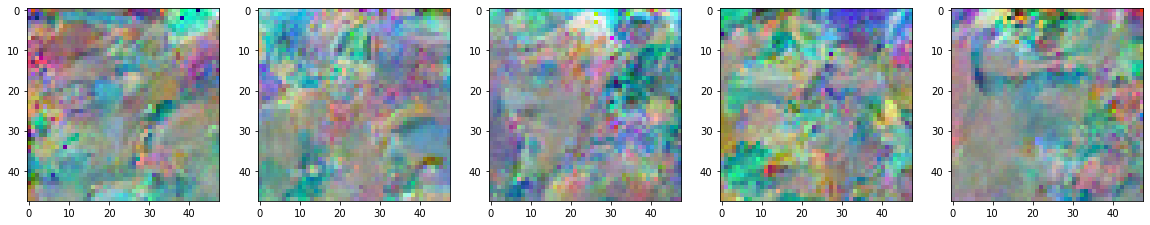

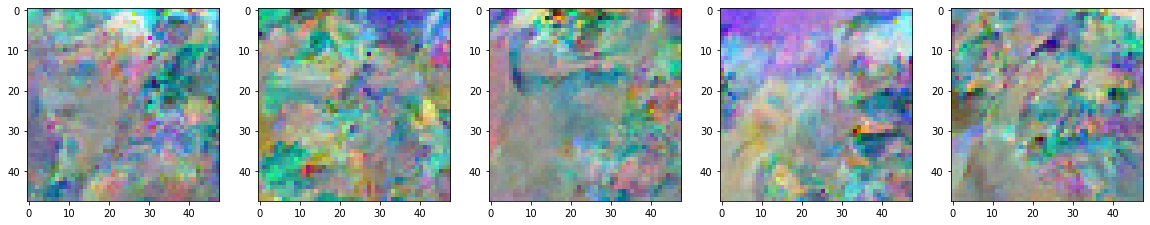

In [19]:
show_d_images(samples)